---------------------------------------

Title: "机器学习实战"

Date: "06/04/2020"

Tips : 正常人CTC数据

Best Regards,

Yuan.SH

---------------------------------------

Please contact with me via follow way:

(a) E-mail :yuansh3354@163.com

(b) QQ :1044532817

(c) WeChat :Y1044532817

---------------------------------------

In [150]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


### Add Moudle

In [267]:
# 模块
from statsmodels.robust.scale import mad
from sklearn.preprocessing import StandardScaler  # 数据预处理
from sklearn.pipeline import Pipeline  # 进行算法串联
from sklearn.model_selection import GridSearchCV  # 网格搜索和交叉验证
from sklearn.model_selection import train_test_split, cross_val_predict  # 数据分割和交叉验证
from sklearn.linear_model import SGDClassifier  # 随机梯度下降分类器
import seaborn as sns  # 数据可视化
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import warnings
import sys
import os
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
wkd = '/Users/yuansh/Desktop/machine_learning/'

# 网格搜索是一种搜索最佳超参数的方法
# 主要用于离散形变量的搜索
# 对应的连续性超参数的搜索方法
# 是 RandomizedSearchCV

# https://blog.csdn.net/weixin_40807247/article/details/82793220

# sys.path.insert(0, os.path.join(wkd + 'scripts', 'util'))

### Classifier

#### Data Load

In [152]:
# 数据导入
sample_freeze = pd.read_table( wkd + 'data/pancan_rnaseq_freeze.tsv.gz', index_col=0) # 样本肿瘤类型
rnaseq_full_df = pd.read_table(wkd + 'data/pancan_rnaseq_freeze.tsv.gz', index_col=0)
mutation_df = pd.read_table(wkd + 'data/pancan_mutation_freeze.tsv.gz', index_col=0)
sample_freeze = pd.read_table(wkd + 'data/sample_freeze.tsv', index_col=0)
mut_burden = pd.read_table(wkd + 'data/mutation_burden_freeze.tsv')

In [153]:
## 默认参数
genes = 'NF1'  # 目标基因
diseases = 'Auto'# 探索的肿瘤类型
folds = 5 # 交叉验证
drop = False # 是否从rna谱中移除目标基因
drop_rasopathy = False # 移除ras 通路相关基因, 这里就是应用到了先验知识
copy_number = False
filter_count = 15
filter_prop = 0.05
num_features_kept = 8000
alphas = '0.1,0.13,0.15,0.18,0.2,0.25,0.3'# 列表推导式 [fun for val in collection if condition]
l1_ratios = '0.15,0.155,0.16,0.2,0.25,0.3,0.4'# 正则化筛选
alt_genes = 'None'
alt_filter_count = 15
alt_filter_prop = 0.05
alt_diseases = 'Auto'
alt_folder = 'Auto'
remove_hyper = False
keep_inter = False
x_matrix ='raw'
shuffled = False
shuffled_before_training = False
no_mutation = True
drop_expression = False
drop_covariates = False

#### 参数设置

In [154]:
### 参数设置
alphas='0.1,0.13,0.15,0.18,0.2,0.25,0.3'
l1_mixing='0.15,0.155,0.16,0.2,0.25,0.3,0.4'
nf1_diseases='BLCA,COAD,GBM,LGG,LUAD,LUSC,OV,PCPG,SARC,SKCM,STAD,UCEC'
ras_diseases='BLCA,CESC,COAD,ESCA,HNSC,LUAD,LUSC,OV,PAAD,PCPG,READ,SKCM,STAD,TGCT,THCA,UCEC'

genes = 'KRAS,HRAS,NRAS' 
genes = genes.split(',')
drop = bool(~drop)
copy_number = bool(~copy_number)
diseases = ras_diseases
diseases = diseases.split(',')  
alphas = alphas
alphas = [float(x) for x in alphas.split(',')] 
l1_ratios = l1_mixing
l1_ratios = [float(x) for x in l1_ratios.split(',')]  
remove_hyper = bool(~remove_hyper)
alt_folder = wkd + 'classifiers/RAS' 
keep_inter = bool(~keep_inter)
shuffled = bool(~shuffled)
alt_genes = 'NF1'
alt_diseases = nf1_diseases


#### 数据展示

In [233]:
"""sample_freeze 样本肿瘤信息矩阵"""
sample_freeze.head()
sample_freeze.shape
"""mut_burden 样本肿瘤突变负荷"""
mut_burden.head()
mut_burden.shape
"""rnaseq_full_df rnaseq表达谱"""
rnaseq_full_df.head()
rnaseq_full_df.shape
"""mutation_df mutation(0-1)矩阵"""
mutation_df.head()
mutation_df.shape

'sample_freeze 样本肿瘤信息矩阵'

,PATIENT_BARCODE,SAMPLE_BARCODE,DISEASE,SUBTYPE
0,TCGA-OR-A5J1,TCGA-OR-A5J1-01,ACC,Not_Applicable
1,TCGA-OR-A5J2,TCGA-OR-A5J2-01,ACC,Not_Applicable
2,TCGA-OR-A5J3,TCGA-OR-A5J3-01,ACC,Not_Applicable
3,TCGA-OR-A5J5,TCGA-OR-A5J5-01,ACC,Not_Applicable
4,TCGA-OR-A5J6,TCGA-OR-A5J6-01,ACC,Not_Applicable


(9062, 4)

'mut_burden 样本肿瘤突变负荷'

,SAMPLE_BARCODE,log10_mut
0,TCGA-IR-A3LL-01,2.537819
1,TCGA-44-4112-01,2.937518
2,TCGA-60-2719-01,2.269513
3,TCGA-A4-7583-01,2.460898
4,TCGA-WQ-AB4B-01,1.832509


(8673, 2)

'rnaseq_full_df rnaseq表达谱'

,A1BG,A1CF,A2BP1,A2LD1,A2M,A2ML1,A4GALT,A4GNT,AAA1,AAAS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
TCGA-IR-A3LL-01,76.4855,0.0000,0.0000,64.4253,3160.62,992.9630,1091.090,0.3909,0.0,775.215,...,677.029,548.866,19.9375,218.530,1116.500,224.0030,533.229,5512.90,752.932,822.909
TCGA-44-4112-01,281.3700,0.0000,1.2048,155.5140,12339.30,0.4016,244.578,1.6064,0.0,694.378,...,498.357,772.691,46.1847,432.128,954.619,19.6787,1011.250,4068.67,358.233,861.847
TCGA-60-2719-01,29.0575,0.0000,0.0000,56.3045,7111.35,259.6100,1812.720,0.6066,0.0,1155.510,...,772.447,1489.730,90.9849,393.055,1166.120,312.9880,916.218,3291.83,1162.180,907.423
TCGA-A4-7583-01,36.9539,0.7412,68.5566,69.7795,4937.62,0.7412,1779.140,12.9702,0.0,879.377,...,173.430,185.659,65.2214,332.407,964.610,11.1173,675.931,4703.35,1434.130,402.816
TCGA-WQ-AB4B-01,90534.8000,929.9660,0.0000,251.4350,39655.70,0.0000,153.846,0.0000,0.0,1005.740,...,255.970,281.286,18.3697,1431.690,731.343,97.5890,619.977,6226.18,610.792,352.468


(9122, 20497)

'mutation_df mutation(0-1)矩阵'

,5S_rRNA,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZYX,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-150,hsa-mir-3171,hsa-mir-466,hsa-mir-5195,hsa-mir-6080,hsa-mir-7162
SAMPLE_BARCODE,,,,,,,,,,,,,,,,,,,,,
TCGA-IR-A3LL-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-44-4112-01,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
TCGA-60-2719-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-A4-7583-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-WQ-AB4B-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(9062, 20938)

提取目标基因的突变信息,作为预测label

In [157]:
common_genes = set(mutation_df.columns).intersection(genes) # 目标基因和mutation矩阵基因交集
common_genes = list(common_genes.intersection(rnaseq_full_df.columns)) # 交集后和rnaseq矩阵交集
y = mutation_df[common_genes] # 提取目标基因中和mutation矩阵和rnaseq交集的基因,在样本中的突变情况
"""y"""
y.head()

,NRAS,KRAS,HRAS
SAMPLE_BARCODE,,,
TCGA-IR-A3LL-01,0,0,0
TCGA-44-4112-01,0,0,0
TCGA-60-2719-01,0,0,0
TCGA-A4-7583-01,0,0,0
TCGA-WQ-AB4B-01,0,0,0


删除目标基因在rnaseq中的表达值,这一步的目的是为了删除和label强相关的基因,从而识别出和目标基因突变相关的其他基因的表达模式(这个理由是我猜的）

In [165]:
if drop:
    if x_matrix == 'raw':
        rnaseq_full_df.drop(common_genes, axis=1, inplace=True)
        '''rnaseq_full_df'''
        rnaseq_full_df.shape

(9122, 20497)

移除ras家族相关的基因

In [166]:
if drop_rasopathy:
    rasopathy_genes = set(['BRAF', 'CBL', 'HRAS', 'KRAS', 'MAP2K1', 'MAP2K2',
                           'NF1', 'NRAS', 'PTPN11', 'RAF1', 'SHOC2', 'SOS1',
                           'SPRED1', 'RIT1'])
    rasopathy_drop = list(rasopathy_genes.intersection(rnaseq_full_df.columns))
    rnaseq_full_df.drop(rasopathy_drop, axis=1, inplace=True)
    '''rnaseq_full_df'''
    rnaseq_full_df.shape

False

整合拷贝数变异信息,判断基因的变异属于激活还是抑制类

In [181]:
if copy_number:
    loss_df = pd.read_table(wkd + 'data/copy_number_loss_status.tsv.gz', index_col=0)
    gain_df = pd.read_table(wkd + 'data/copy_number_gain_status.tsv.gz', index_col=0)
    cancer_genes_df = pd.read_table(wkd + 'data/vogelstein_cancergenes.tsv') # 癌基因分类表
    
    genes_sub = cancer_genes_df[cancer_genes_df['Gene Symbol'].isin(common_genes)]# 获取基因信息
    '''
    基因信息
    '''
    genes_sub.head()
    tumor_suppressor = genes_sub[genes_sub['Classification*'] == 'TSG'] # 提取抑癌基因
    oncogene = genes_sub[genes_sub['Classification*'] == 'Oncogene'] # 提取原癌基因
    copy_loss_sub = loss_df[tumor_suppressor['Gene Symbol']] # 如果是抑癌基因则获取拷贝数缺失信息
    copy_gain_sub = gain_df[oncogene['Gene Symbol']]  # 如果是原癌基因则获取拷贝数增加信息
    
    genes_sub.head()
    tumor_suppressor = genes_sub[genes_sub['Classification*'] == 'TSG'] # 提取抑癌基因
    oncogene = genes_sub[genes_sub['Classification*'] == 'Oncogene'] # 提取原癌基因
    copy_loss_sub = loss_df[tumor_suppressor['Gene Symbol']] # 如果是抑癌基因则获取拷贝数缺失信息
    copy_gain_sub = gain_df[oncogene['Gene Symbol']]  # 如果是原癌基因则获取拷贝数增加信息
    
    copy_loss_sub.columns = [col + '_loss' for col in copy_loss_sub.columns] # 修改列名
    copy_gain_sub.columns = [col + '_gain' for col in copy_gain_sub.columns]

    # Add columns to y matrix
    y = y.join(copy_loss_sub) # 合并拷贝数变异信息
    y = y.join(copy_gain_sub)

    # 数据清洗
    y = y.fillna(0) 
    y = y.astype(int)
    # 如果不考虑突变信息则删除突变数据,只保留拷贝数变异数据
    if not no_mutation:
        y.drop(genes, axis=1, inplace=True)

数据处理

In [208]:
y['total_status'] = y.max(axis=1) # 三个目标基因中只要有一种基因突变则人为患者为突变型 
y = y.reset_index().merge(sample_freeze,
                          how='left').set_index('SAMPLE_BARCODE') # 合并样本疾病类型
'''y'''
y.head()


count_df = y.groupby('DISEASE').sum() # 计算不同癌的型基因突变频率
prop_df = count_df.divide(y['DISEASE'].value_counts(sort=False).sort_index(),
                          axis=0)



count_table = count_df.merge(prop_df, left_index=True, right_index=True,
                             suffixes=('_count', '_proportion'))
count_table.to_csv("count_table_file.csv")


,NRAS,KRAS,HRAS,HRAS_gain,KRAS_gain,NRAS_gain,total_status,PATIENT_BARCODE,DISEASE,SUBTYPE
SAMPLE_BARCODE,,,,,,,,,,
TCGA-IR-A3LL-01,0,0,0,0,0,0,0,TCGA-IR-A3LL,CESC,SquamousCarcinoma
TCGA-44-4112-01,0,0,0,0,0,0,0,TCGA-44-4112,LUAD,Not_Applicable
TCGA-60-2719-01,0,0,0,0,0,0,0,TCGA-60-2719,LUSC,Not_Applicable
TCGA-A4-7583-01,0,0,0,0,0,0,0,TCGA-A4-7583,KIRP,Not_Applicable
TCGA-WQ-AB4B-01,0,0,0,0,0,0,0,TCGA-WQ-AB4B,LIHC,Not_Applicable


移除超高肿瘤突变负荷样本

In [216]:
y_df = y[y.DISEASE.isin(diseases)].total_status # 提取指定疾病的基因患者突变信息
common_samples = list(set(y_df.index) & set(rnaseq_full_df.index)) # 提取指定疾病的基因表达谱
y_df = y_df.loc[common_samples]
rnaseq_df = rnaseq_full_df.loc[y_df.index, :]
if remove_hyper:
    burden_filter = mut_burden['log10_mut'] < 5 * mut_burden['log10_mut'].std()
    mut_burden = mut_burden[burden_filter]

y_matrix = mut_burden.merge(pd.DataFrame(y_df), right_index=True,
                            left_on='SAMPLE_BARCODE').set_index('SAMPLE_BARCODE')


添加协变量信息





In [234]:
y_sub = y.loc[y_matrix.index]['DISEASE']
covar_dummy = pd.get_dummies(sample_freeze['DISEASE']).astype(int)
covar_dummy.index = sample_freeze['SAMPLE_BARCODE']
covar = covar_dummy.merge(y_matrix, right_index=True, left_index=True)
covar = covar.drop('total_status', axis=1)


'''covar 疾病协变量矩阵'''
covar.head()
"""y_sub 样本肿瘤信息"""
y_sub.head()
"""y_df 目标基因患者突变状态"""
y_df.head()

'covar 疾病协变量矩阵'

,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,...,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM,log10_mut
SAMPLE_BARCODE,,,,,,,,,,,,,,,,,,,,,
TCGA-2F-A9KO-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.689309
TCGA-2F-A9KP-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.113943
TCGA-2F-A9KQ-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.799341
TCGA-2F-A9KR-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.326336
TCGA-2F-A9KT-01,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.525045


'y_sub 样本肿瘤信息'

SAMPLE_BARCODE
TCGA-IR-A3LL-01    CESC
TCGA-44-4112-01    LUAD
TCGA-60-2719-01    LUSC
TCGA-66-2792-01    LUSC
TCGA-D1-A0ZZ-01    UCEC
Name: DISEASE, dtype: object

'y_df 目标基因患者突变状态'

SAMPLE_BARCODE
TCGA-H6-A45N-01    0
TCGA-EA-A411-01    0
TCGA-FY-A40L-01    0
TCGA-XE-AANI-01    0
TCGA-P3-A5Q6-01    0
Name: total_status, dtype: int64

In [244]:
#y_df = y_df.loc[y_sub.index] # 提取ylabel
#strat = y_sub.str.cat(y_df.astype(str)) # 合并疾病和突变类型
#x_df = rnaseq_df.loc[y_df.index, :] # 提取 x
'''疾病类型+0/1'''
'''例如: CESC0'''
'''表示患者属于cesc 且目标基因未突变'''
strat.head()

'疾病类型+0/1'

'例如: CESC0'

'表示患者属于cesc 且目标基因未突变'

SAMPLE_BARCODE
TCGA-IR-A3LL-01    CESC0
TCGA-44-4112-01    LUAD0
TCGA-60-2719-01    LUSC0
TCGA-66-2792-01    LUSC0
TCGA-D1-A0ZZ-01    UCEC0
Name: DISEASE, dtype: object

提取绝对中位差最大的基因并对数据进行标准化

In [257]:
# Subset x matrix to MAD genes and scale
if x_matrix == 'raw':
    med_dev = pd.DataFrame(mad(x_df), index=x_df.columns)
    mad_genes = med_dev.sort_values(by=0, ascending=False)\
                       .iloc[0:num_features_kept].index.tolist()
    x_df = x_df.loc[:, mad_genes]

fitted_scaler = StandardScaler().fit(x_df)
x_df_update = pd.DataFrame(fitted_scaler.transform(x_df),
                           columns=x_df.columns)
x_df_update.index = x_df.index
x_df = x_df_update.merge(covar, left_index=True, right_index=True)
x_df.head()
x_df.shape

,ACTB,GAPDH,EEF1A1,COL1A1,B2M,CD74,FN1,ACTG1,TPT1,FTL,...,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM,log10_mut
SAMPLE_BARCODE,,,,,,,,,,,,,,,,,,,,,
TCGA-IR-A3LL-01,1.182046,0.514477,-0.677936,-0.505524,0.879428,3.415722,-0.429955,-0.566778,0.754844,0.358000,...,0,0,0,0,0,0,0,0,0,2.537819
TCGA-44-4112-01,1.557135,-0.182370,0.871035,-0.276410,0.199495,1.335581,-0.024927,0.816420,1.194310,0.722729,...,0,0,0,0,0,0,0,0,0,2.937518
TCGA-60-2719-01,-0.139493,0.126739,-0.214535,-0.407143,-0.717224,-0.344357,-0.375393,-0.564679,-1.024160,-0.190193,...,0,0,0,0,0,0,0,0,0,2.269513
TCGA-66-2792-01,-0.800433,0.876710,-0.775344,0.008190,-0.725851,-0.670311,-0.249440,1.436868,-0.766385,-0.628508,...,0,0,0,0,0,0,0,0,0,2.184691
TCGA-D1-A0ZZ-01,-0.651369,-0.758039,-0.257163,-0.439442,-1.225844,-0.858715,-0.445951,-0.476754,-0.536916,-0.721520,...,0,0,0,0,0,0,1,0,0,1.799341


(4742, 8034)

基因扰动

In [254]:
if shuffled_before_training:
    # Shuffle genes
    x_train_genes = x_df.iloc[:, range(num_features_kept)]
    rnaseq_shuffled_df = x_train_genes.apply(shuffle_columns, axis=1,
                                             result_type='broadcast')

    x_train_cov = x_df.iloc[:, num_features_kept:]
    x_df = pd.concat([rnaseq_shuffled_df, x_train_cov], axis=1)
    x_df.head()
    x_df.shape


构建弹性神经网络

In [268]:
# Build classifier pipeline
x_train, x_test, y_train, y_test = train_test_split(x_df, y_df, 
                                                    test_size=0.1, # 验证集比例
                                                    random_state=0, # 随机种子
                                                    stratify=strat #分层抽样
                                                   )
# 网格搜索超参数表
clf_parameters = {'classify__loss': ['log'], # log损失函数,针对二分类变量
                  'classify__penalty': ['elasticnet'], # 使用弹性网络
                  'classify__alpha': alphas, # 搜索步长
                  'classify__l1_ratio': l1_ratios # 正则化率
                 }

estimator = Pipeline(steps=[('classify', SGDClassifier(random_state=0, 
                                                       class_weight='balanced', # 各个参数权重相同
                                                       loss='log', # log损失函数
                                                       max_iter=5, # 迭代次数
                                                       tol=None))])

cv_pipeline = GridSearchCV(estimator=estimator, param_grid=clf_parameters,
                           n_jobs=-1, cv=folds, scoring='roc_auc',
                           return_train_score=True)
cv_pipeline.fit(X=x_train, y=y_train)
# alpha 有7中, l1有7种, 网格搜索法一共搜索49种组合
cv_results = pd.concat([pd.DataFrame(cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)
"""最佳参数组合"""
cv_pipeline.best_params_

cv_results.head()

'最佳参数组合'

{'classify__alpha': 0.1,
 'classify__l1_ratio': 0.15,
 'classify__loss': 'log',
 'classify__penalty': 'elasticnet'}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,split0_test_score,split1_test_score,...,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty
0,12.436195,0.056998,0.372348,0.059474,0.1,0.15,log,elasticnet,0.872206,0.869915,...,0.909797,0.907161,0.912684,0.907027,0.907938,0.003211,0.1,0.150,log,elasticnet
1,12.435449,0.095200,0.361305,0.087802,0.1,0.155,log,elasticnet,0.867986,0.869004,...,0.906615,0.905949,0.911334,0.904677,0.906216,0.002917,0.1,0.155,log,elasticnet
2,7.535474,4.013275,0.183587,0.123183,0.1,0.16,log,elasticnet,0.869718,0.867042,...,0.903609,0.903376,0.909240,0.902480,0.903588,0.003230,0.1,0.160,log,elasticnet
3,4.272839,0.075516,0.096160,0.021087,0.1,0.2,log,elasticnet,0.861378,0.860614,...,0.890236,0.886255,0.896182,0.886414,0.889025,0.003901,0.1,0.200,log,elasticnet
4,4.180178,0.135997,0.104040,0.023466,0.1,0.25,log,elasticnet,0.857027,0.852553,...,0.872911,0.871078,0.881692,0.871431,0.873397,0.004260,0.1,0.250,log,elasticnet


In [ ]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')
plt.tight_layout()
plt.savefig(cv_heatmap_file, dpi=600, bbox_inches='tight')
plt.close()

# Get predictions
y_predict_train = cv_pipeline.decision_function(x_train)
y_predict_test = cv_pipeline.decision_function(x_test)
metrics_train = get_threshold_metrics(y_train, y_predict_train,
                                      drop_intermediate=keep_inter)
metrics_test = get_threshold_metrics(y_test, y_predict_test,
                                     drop_intermediate=keep_inter)


classify__alpha,0.10,0.13,0.15,0.18,0.20,0.25,0.30
classify__l1_ratio,,,,,,,
0.150,0.864560,0.853613,0.846794,0.837709,0.830958,0.816076,0.801017
0.155,0.862616,0.852454,0.845480,0.836184,0.828945,0.813887,0.797663
0.160,0.861776,0.851623,0.844242,0.835147,0.826117,0.811707,0.794538
0.200,0.853776,0.841753,0.832105,0.819892,0.813177,0.792522,0.776949
0.250,0.845492,0.828373,0.817445,0.803704,0.794467,0.775106,0.760059


Text(0.5, 16.0, 'Regularization strength multiplier (alpha)')

Text(34.0, 0.5, 'Elastic net mixing parameter (l1_ratio)')

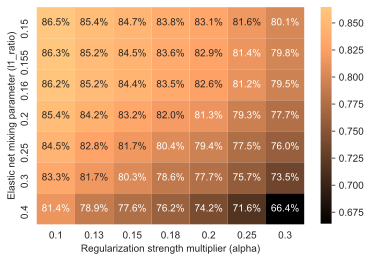

In [278]:
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='classify__l1_ratio',
                              columns='classify__alpha')

cv_score_mat.head()
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%', cmap="copper")
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')

调用decision方法进行预测

In [281]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
y_predict_train = cv_pipeline.decision_function(x_train)
y_predict_test = cv_pipeline.decision_function(x_test)

ROC评估

In [293]:
def get_threshold_metrics(y_true, y_pred, drop_intermediate=False,
                          disease='all'):
    import pandas as pd
    from sklearn.metrics import roc_auc_score, roc_curve
    from sklearn.metrics import precision_recall_curve, average_precision_score

    roc_columns = ['fpr', 'tpr', 'threshold']
    pr_columns = ['precision', 'recall', 'threshold']

    if drop_intermediate:
        roc_items = zip(roc_columns,
                        roc_curve(y_true, y_pred, drop_intermediate=False))
    else:
        roc_items = zip(roc_columns, roc_curve(y_true, y_pred))

    roc_df = pd.DataFrame.from_dict(dict(roc_items))

    prec, rec, thresh = precision_recall_curve(y_true, y_pred)
    pr_df = pd.DataFrame.from_records([prec, rec]).T
    pr_df = pd.concat([pr_df, pd.Series(thresh)], ignore_index=True, axis=1)
    pr_df.columns = pr_columns

    auroc = roc_auc_score(y_true, y_pred, average='weighted')
    aupr = average_precision_score(y_true, y_pred, average='weighted')

    return {'auroc': auroc, 'aupr': aupr, 'roc_df': roc_df,
            'pr_df': pr_df, 'disease': disease}

metrics_train = get_threshold_metrics(y_train, y_predict_train,
                                      drop_intermediate=keep_inter)
metrics_test = get_threshold_metrics(y_test, y_predict_test,
                                     drop_intermediate=keep_inter)
'''训练集'''
metrics_train['roc_df'].head()
'''验证集'''
metrics_test['roc_df'].head()

'训练集'

,fpr,tpr,threshold
0,0.0,0.000000,9.479566
1,0.0,0.001105,8.479566
2,0.0,0.002210,4.874637
3,0.0,0.003315,4.293006
4,0.0,0.004420,3.904473


'验证集'

,fpr,tpr,threshold
0,0.000000,0.000000,4.682363
1,0.002681,0.000000,3.682363
2,0.005362,0.000000,3.059587
3,0.005362,0.009804,2.924982
4,0.005362,0.019608,2.515022


使用网格搜索法得出的最佳参数模型

进行交叉验证

In [296]:
# cv_pipeline.best_estimator_ 网格算法最佳参数模型
y_cv = cross_val_predict(cv_pipeline.best_estimator_, X=x_train, y=y_train,
                         cv=folds, method='decision_function')
metrics_cv = get_threshold_metrics(y_train, y_cv,
                                   drop_intermediate=keep_inter)

In [302]:
if keep_inter:
    train_roc = metrics_train['roc_df']
    train_roc = train_roc.assign(train_type='train')
    test_roc = metrics_test['roc_df']
    test_roc = test_roc.assign(train_type='test')
    cv_roc = metrics_cv['roc_df']
    cv_roc = cv_roc.assign(train_type='cv')
    full_roc_df = pd.concat([train_roc, test_roc, cv_roc]) # rbind
    full_roc_df.assign(disease='PanCan')

<Figure size 216x216 with 0 Axes>

(-0.05, 1.05, -0.05, 1.05)

(0.0, 1.0)

(0.0, 1.05)

Text(0.5, 0, 'False Positive Rate')

Text(0, 0.5, 'True Positive Rate')

Text(0.5, 1.0, '')

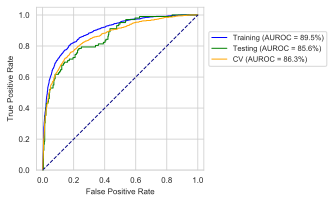

In [308]:
sns.set_style("whitegrid")
plt.figure(figsize=(3, 3))
total_auroc = {}
colors = ['blue', 'green', 'orange', 'grey']
idx = 0

metrics_list = [('Training', metrics_train), ('Testing', metrics_test),
                ('CV', metrics_cv)]
for label, metrics in metrics_list:

    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
             label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']),
             linewidth=1, c=colors[idx])
    total_auroc[label] = metrics['auroc']
    idx += 1

plt.axis('equal')
plt.plot([0, 1], [0, 1], color='navy', linewidth=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)

In [ ]:
sns.set_style("whitegrid")
plt.figure(figsize=(3, 3))
total_aupr = {}
colors = ['blue', 'green', 'orange', 'grey']
idx = 0

metrics_list = [('Training', metrics_train), ('Testing', metrics_test),
                ('CV', metrics_cv)]

for label, metrics in matrics_list :
    pr_df = metrics['pr_df']
    plt.plot(pr_df.recall, pr_df.precision,
            label = '{} (AUPR = : {:.1%})'.format)

In [ ]:

if shuffled:
    metrics_list += [('Random', metrics_shuffled)]

for label, metrics in metrics_list:
    pr_df = metrics['pr_df']
    plt.plot(pr_df.recall, pr_df.precision,
             '''''' "{} {} {}".format 格式化输出,
             label='{} (AUPR = {:.1%})'.format(label, metrics['aupr']),
             linewidth=1, c=colors[idx])
    total_aupr[label] = metrics['aupr']
    idx += 1

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)